In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [3]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

In [4]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [5]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [6]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [7]:
def new_FC_layer(x,units,activation,use_bias,name,reuse):
        num_ip = int(x.shape[1])
        num_op = units
        
        #kernel initializer
        #if kernel_initializer==xavier_initializer:
        #    initializer = tf.contrib.layers.xavier_initializer
        #    weight = tf.Variable(initializer([num_ip, num_op]),name='Weight')
        #else:
        
        if name:
            if reuse == True:
                with tf.variable_scope(name,reuse = tf.AUTO_REUSE):
                    weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.contrib.layers.xavier_initializer())
                    bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer())
            else:
                with tf.variable_scope(name):
                    weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.contrib.layers.xavier_initializer())
                    bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer())
        else:
            weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.contrib.layers.xavier_initializer())
            bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer())
        
        if use_bias==False:
            layer = tf.matmul(x,weight)
        else:
            layer = tf.add(tf.matmul(x,weight),bias)
        if activation:
            layer = activation(layer)
        return layer

In [8]:
h_layer1 = new_FC_layer(x,500,activation = tf.nn.sigmoid,use_bias=True,name='h_layer1',reuse=False)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
h_layer2= new_FC_layer(h_layer1,512,activation = tf.nn.relu,use_bias=True,name ='h_layer2',reuse=False)

In [10]:
h_layer3= new_FC_layer(h_layer2,512,activation = tf.nn.relu,use_bias=True,name ='h_layer3',reuse=True)

In [11]:
logits = new_FC_layer(h_layer3,num_classes,activation = None,use_bias=True,name='op_layer',reuse=True)

In [12]:
#tf.global_variables()

In [13]:
y_pred = tf.nn.softmax(logits)

In [14]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [15]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [16]:
cost = tf.reduce_mean(cross_entropy)

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)

In [18]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [19]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
session= tf.Session()

In [21]:
session.run(tf.global_variables_initializer())

In [22]:
batch_size = 100

In [23]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [24]:
def optimize(num_iterations):
    loss_list=[]
    acc_list=[]
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        if i % 100 == 0:
            loss=session.run(cost, feed_dict=feed_dict_train)
            #acc = session.run(accuracy, feed_dict=feed_dict_train)
            loss_list.append(loss)
            #acc_list.append(acc)
            plt.plot(loss_list)
            #plt.plot(acc_list)

In [25]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [26]:
def print_confusion_matrix():
    cls_true = data.y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(cm)

In [27]:
print_accuracy()

Accuracy on test-set: 8.8%


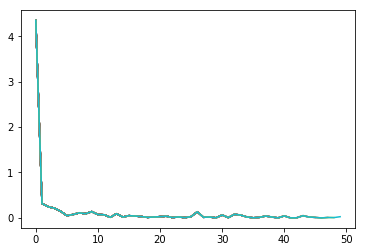

In [28]:
optimize(num_iterations=5000)

In [29]:
print_accuracy()

Accuracy on test-set: 97.4%


[[ 966    0    0    0    1    0    4    4    3    2]
 [   0 1126    4    0    0    0    2    0    3    0]
 [   6    1 1009    8    1    0    1    3    3    0]
 [   0    0    8  975    0    4    0    5    8   10]
 [   1    3    2    0  950    1   15    1    1    8]
 [   2    0    0    5    1  864   10    1    8    1]
 [   4    1    0    1    5    1  945    0    1    0]
 [   1    6   12    1    1    0    0 1004    1    2]
 [   3    0   17    2    2    2    6    4  936    2]
 [   2    5    0    9   10    7    3   10    2  961]]


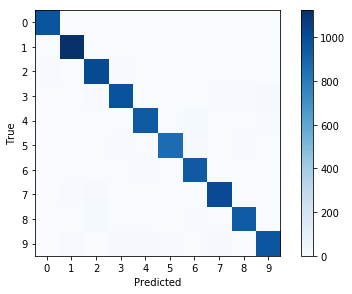

In [30]:
cm = print_confusion_matrix()

In [31]:
def find_performance_matrix(cm, num_classes):
    performance_matrix = [[0, 0, 0]] * num_classes
    for class_num in range(num_classes):
        performance_matrix[class_num][0] = find_precision(cm, class_num)
    for class_num in range(num_classes):
        performance_matrix[class_num][1] = find_recall_rate(cm, class_num)
    for class_num in range(num_classes):
        performance_matrix[class_num][2] = find_f_score(performance_matrix[class_num])

    #find mean precision, mean recall rate and mean f score
    for metric in range(3):
        total = 0
        for i in range(num_classes):
            total += performance_matrix[i][metric]

        performance_matrix[num_classes - 1][metric] = total / num_classes

    round_off_performance_matrix(performance_matrix)

    return performance_matrix

def round_off_performance_matrix(performance_matrix):
    for i in range(len(performance_matrix)):
        for j in range(len(performance_matrix[i])):
            performance_matrix[i][j] = round(performance_matrix[i][j], 2)


def find_precision(cm, class_num):
    total_samples_classfied_as_class_num = 0
    for i in range(num_classes):
        total_samples_classfied_as_class_num += cm[i][class_num]
    precision_rate = (cm[class_num][class_num] / total_samples_classfied_as_class_num) * 100

    return precision_rate

def find_recall_rate(cm, class_num):
    total_samples_in_class = 0
    for j in range(num_classes):
        total_samples_in_class += cm[class_num][j]
    recall_rate = (cm[class_num][class_num] / total_samples_in_class) * 100

    return recall_rate

def find_f_score(array):
    precision = array[0]
    recall = array[1]
    f_score = (precision * recall) / ((precision + recall) / 2)

    return f_score

In [32]:
pm = find_performance_matrix(cm,num_classes)
print(pm)

[[97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34], [97.46, 95.24, 96.34]]


In [33]:
f_score = pm[-1][-1]
print(f_score)

96.34


In [34]:
#saver = tf.train.Saver()
#save_path = saver.save(session, "/Users/momo/Documents/DL/Tuts/Tf/new/model1.ckpt",global_step=1000)
#print("Model saved in path: %s" % save_path)

In [36]:
session.close()